In [7]:
#Imports used
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
import gc
import librosa
import torch
from func.MFCC import calcMFCC
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
plt.style.use('dark_background')

In [8]:
def wavelet_denoise(signal, wavelet='db1', level=1):
    # 小波分解
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # 设置阈值（可以根据需求调整阈值）
    threshold = np.median(np.abs(coeffs[-level])) / 0.6745
    
    # 对高频分量应用软阈值去噪
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') if i > 0 else c for i, c in enumerate(coeffs)]
    
    # 重构信号
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal




# 带通滤波
def band_pass_filter(original_signal, order, fc1,fc2, fs):
    b, a = signal.butter(N=order, Wn=[2*fc1/fs,2*fc2/fs], btype='bandpass') # 采用的是带通 b，a: IIR滤波器的分子（b）和分母（a）多项式系数向量
    new_signal = signal.lfilter(b, a, original_signal)
    return new_signal


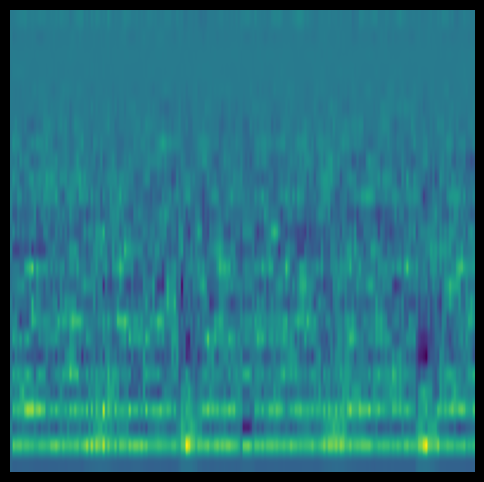

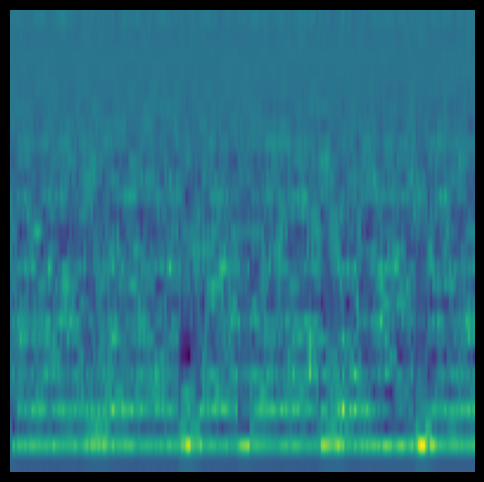

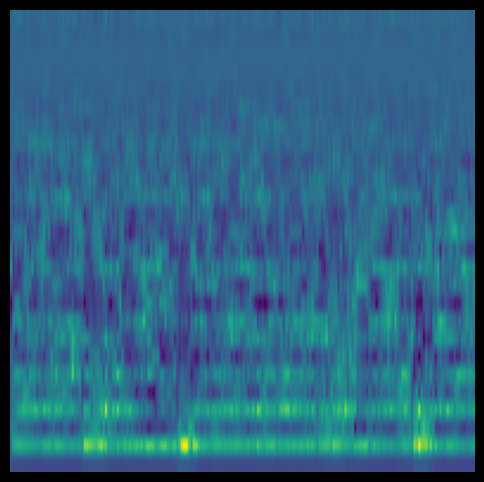

In [10]:
#切割成5S
import numpy as np
import pywt
import torch
def Limit(S, Fs, target_sec=2):
    target_samples = int(target_sec * Fs)
    current_samples = len(S)
    
    if current_samples >= target_samples:
        return S[:target_samples]  # 截断
    else:
        # 高效补零（预分配）
        padded = np.zeros(target_samples, dtype=S.dtype)
        padded[:current_samples] = S
        return padde

def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

import os
output_directory = './image_data_1/'
f = "/home/qziedu/pcg/image_data"
file_folder = '/home/qziedu/pcg/DATA/database_two_categorie'
#class_name = ["normal","artfact","murmur","extrastole","extrahls"] #,
class_name = ["normal","abnormal"]
#print(sorted(os.listdir(file_folder)))
for file_type in sorted(os.listdir(file_folder)):
    #print(file_type)
    if not file_type.startswith('.') and file_type =="abnormal" or file_type == "normal":#
        file_path = os.path.join(file_folder,file_type)
        #print(file_path)
        filenames = sorted(os.listdir(file_path))
        #print( f"{file_type}===={filename}\n")
        for filename in filenames:
            input_path = os.path.join(file_path,filename)
            dist_dir = output_directory+file_type.lower()  #输出子目录路径如"output/normal/")
            file_dist_path = os.path.join(dist_dir,filename.replace(".wav",""))
            #print(f"{file_type}===={file_dist_path}\n")
            
            sound_info, frame_rate = get_wav_info(input_path)
            sig = Limit(sound_info,frame_rate,2)
            #print(len(sig))
            #denoised_signal=sig
            denoised_signal = band_pass_filter(sig, 2, 25,400, frame_rate)
            max_data = np.max(denoised_signal)
            min_data = np.min(denoised_signal)
            norm_signal = (denoised_signal- min_data)/(max_data - min_data)
            denoised_signal = norm_signal - 0.5
            MFCC_signal= calcMFCC(denoised_signal,frame_rate)       
            if(file_type == "abnormal"):
                start = len(sig)//2
                target = frame_rate*2
               # print(f"len(sound_info)={len(sound_info)}")
                #print(f"target={target}")
                for i in range(3):
                    if(start + target < len(sound_info)):
                        #print(f"start = {start}")                  
                        kc_sig = sound_info[start:start + target]
                        #kc_denoised_signal = kc_sig
                        kc_denoised_signal= band_pass_filter(kc_sig, 2, 25,400, frame_rate)
                        max_data = np.max(  kc_denoised_signal)
                        min_data = np.min(  kc_denoised_signal)
                        norm_signal = ( kc_denoised_signal- min_data)/(max_data - min_data)
                        kc_denoised_signal = norm_signal - 0.5
                        MFCC_signal_bc= calcMFCC(kc_denoised_signal,frame_rate)
                        plt.figure(figsize=(6, 6))
                        im_bc = plt.imshow(MFCC_signal_bc.T, 
                                       cmap='viridis',
                                       aspect='auto',
                                       origin='lower',
                                       extent=[0,MFCC_signal_bc.shape[1], 0, MFCC_signal_bc.shape[0]])
                        plt.axis('off')
                        plt.savefig(f'{file_dist_path}_{i}.png')
                        start += len(sig)//2
                
            plt.figure(figsize=(6, 6))
            im = plt.imshow(MFCC_signal.T, 
                           cmap='viridis',
                           aspect='auto',
                           origin='lower',
                           extent=[0,MFCC_signal.shape[1], 0, MFCC_signal.shape[0]])
            plt.axis('off')
            plt.savefig(f'{file_dist_path}.png')
            plt.close()
           # break

In [4]:
import torch
import torchvision.transforms as transforms
import cv2
import numpy as np
from tqdm import tqdm
import os
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
N_CHANNELS = 1
def load_data(data):
    X = []
    y = []
    
    # Define augmentation transforms
    augment_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(72),  # 0.2 * 360 = 72 degrees
        transforms.ToTensor()
    ])
    i = 0
    for file_type in sorted(os.listdir(data)):
        if not file_type.startswith('.'):
            if file_type in ['abnormal']:
                label = 1
            elif file_type in ['normal']:
                label = 0
            
            for filename in tqdm(sorted(os.listdir(os.path.join(data, file_type)))):
                image = cv2.imread(os.path.join(data, file_type, filename))
                
                if image is not None:
                    # Resize image
                    #image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                    image = np.expand_dims(image, axis=-1)
                    image = image.astype(np.float32) / 255.0
                    
                    # Convert to tensor
                    image_tensor = torch.from_numpy(image).permute(2, 0, 1)
                    # if file_type in ['normal'] and i <300:
                    #     augmented_image = augment_transform(image)
                    #     X.append(augmented_image)
                    #     y.append(label)
                    #     i += 1

                    
                    X.append(image_tensor)
                    y.append(label)
    
    X = torch.stack(X)
    y = torch.tensor(y)
    return X, y

# Usage example
X_train, y_train = load_data('./image_data_1/')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2575/2575 [00:19<00:00, 134.92it/s]


## Printing count of each class to make sure there is no imbalance in dataset

In [5]:
#Getting counts of each labels
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 2575, 1: 2660}

In [6]:
X_train.shape, y_train.shape

(torch.Size([5235, 1, 256, 256]), torch.Size([5235]))

In [9]:
import torch
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import gc


# 2. 数据集划分 (PyTorch方式)
def split_dataset(X, y, test_size=0.2, random_seed=42):
    # 使用sklearn的划分保持相同逻辑
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_seed
    )
    
    # 转换为PyTorch Dataset
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    
    return train_dataset, test_dataset

train_dataset, test_dataset = split_dataset(X_train, y_train)

# 3. 数据加载器创建
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

features_train = train_dataset.tensors[0].cpu().numpy()  # 确保在CPU上
labels_train = train_dataset.tensors[1].cpu().numpy()
features_test = test_dataset.tensors[0].cpu().numpy()
labels_test = test_dataset.tensors[1].cpu().numpy()

np.savez_compressed('/home/qziedu/pcg/train_data/data_2/train/train_x_3.npz',features =features_train ,lables = labels_train)
np.savez_compressed('/home/qziedu/pcg/train_data/data_2/test/test_x_3.npz',features =features_test ,lables = labels_test)


# 内存清理
gc.collect()

11241253

In [ ]:
## Step 4 : Make the CNN model and train the model with the respective parameters

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
train_data = np.load('/home/qziedu/pcg/train_data/data_2/train/train_x_3.npz')
train_x = train_data['features']
train_y = train_data['lables']

test_data = np.load('/home/qziedu/pcg/train_data/data_2/test/test_x_3.npz')
test_x, test_y = test_data['features'], test_data['lables']
train_dataset = TensorDataset(
    torch.from_numpy(train_x).float(),
    torch.from_numpy(train_y).long()
)
test_dataset = TensorDataset(
    torch.from_numpy(test_x).float(),
    torch.from_numpy(test_y).long()
)
# 3. 创建 DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from func.trans import TransformerLayer
from func.attention import CABlock,SEBlock,CBAM
import torch.nn.functional as F
class CNNModel_1(nn.Module):
    def __init__(self, stride=1):
        super(CNNModel_1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        #x = self.fc(x)
        return x
class CNNModel_2(nn.Module):
    def __init__(self,embed_dim=64, num_heads=4, ff_dim=64, dropout_rate=0.1):
        super(CNNModel_2, self).__init__()
        self.conv5 = nn.Conv2d(64,64,kernel_size=5,padding=2)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 16, kernel_size=3, padding=1)       
        self.bn4 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.bn5(self.conv5(x))))#128
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))       
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        return x
class CombinedModel(nn.Module):
    def __init__(self,attensionChannel = 128): #16
        super(CombinedModel, self).__init__()
        self.cnn_model_1 = CNNModel_1()
        self.cnn_model_2 = CNNModel_2() 
        self.cov_pool = nn.Sequential(
            nn.Conv2d(64,16,kernel_size=1,stride=2),
            nn.MaxPool2d(2, stride=2),# 32×32 → 16×16（浅层保留细节）
            nn.Conv2d(16,16,kernel_size=1,stride=2),
            nn.MaxPool2d(2, stride=2) # 32×32 → 16×16（浅层保留细节）
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(16*2*2, 256),  
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 2)  # 
            )
    def forward(self,x_mfcc):
        cnn_output_1 = self.cnn_model_1(x_mfcc ) # (16,128,32,32 )
        #print(cnn_output_1.shape)
        #cnn_output_1_1  = self.pool(self.conv1(cnn_output_1 )))
        cnn_output_1_1 = self.cov_pool(cnn_output_1)
        #print(cnn_output_1_1.shape)
        cnn_output_2 = self.cnn_model_2(cnn_output_1 )  #(32,16,2,2)
        
        fused = cnn_output_1_1 + cnn_output_2 
        #fused = torch.concat([cnn_output_1_1,cnn_output_2],dim=1)
        cnn_outputs =   fused
        cnn_outputs = self.fc(cnn_outputs)
        combined_output = cnn_outputs  
        return combined_output

In [3]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CombinedModel()
print(device)
model.to(device)
summary(model, input_size=(1, 256, 256))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
           Dropout-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           4,640
              ReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          18,496
              ReLU-9           [-1, 64, 64, 64]               0
        MaxPool2d-10           [-1, 64, 32, 32]               0
          Dropout-11           [-1, 64, 32, 32]               0
       CNNModel_1-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 16, 16, 16]           1,040
        MaxPool2d-14            

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

def train_and_evaluate(model, train_loader, test_loader, epochs=30):
    class_weights = torch.tensor([0.5,1]).to(device) 
    criterion = nn.CrossEntropyLoss(weight=class_weights)#weight=class_weights
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    
    # 记录训练过程
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # 训练前评估
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        initial_acc = 100 * correct / total
        test_accuracies.append(initial_acc)
        print(f'Initial Accuracy: {initial_acc:.2f}%')
    
    # 训练循环
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_correct = 0
        epoch_total = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            epoch_total += labels.size(0)
            epoch_correct += (predicted == labels).sum().item()
        
        # 记录训练指标
        train_loss = epoch_loss / len(train_loader)
        train_acc = 100 * epoch_correct / epoch_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # 测试集评估
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            test_acc = 100 * correct / total
            test_accuracies.append(test_acc)
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    # 最终评估
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
    
    return model, y_true, y_pred, train_losses, train_accuracies, test_accuracies

# 训练模型
model = CombinedModel().to(device)
model, y_true, y_pred, train_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, epochs=80)



Initial Accuracy: 51.77%
Epoch [1/80], Loss: 0.3795, Train Acc: 77.70%, Test Acc: 48.81%
Epoch [2/80], Loss: 0.2538, Train Acc: 85.32%, Test Acc: 68.19%
Epoch [3/80], Loss: 0.2291, Train Acc: 86.68%, Test Acc: 83.09%
Epoch [4/80], Loss: 0.2108, Train Acc: 87.23%, Test Acc: 85.20%
Epoch [5/80], Loss: 0.2019, Train Acc: 88.30%, Test Acc: 90.74%
Epoch [6/80], Loss: 0.1956, Train Acc: 88.20%, Test Acc: 86.53%
Epoch [7/80], Loss: 0.1881, Train Acc: 88.73%, Test Acc: 90.26%
Epoch [8/80], Loss: 0.1817, Train Acc: 88.44%, Test Acc: 91.21%
Epoch [9/80], Loss: 0.1831, Train Acc: 89.40%, Test Acc: 90.74%
Epoch [10/80], Loss: 0.1672, Train Acc: 90.50%, Test Acc: 89.78%
Epoch [11/80], Loss: 0.1739, Train Acc: 89.64%, Test Acc: 91.21%
Epoch [12/80], Loss: 0.1712, Train Acc: 90.11%, Test Acc: 90.74%
Epoch [13/80], Loss: 0.1671, Train Acc: 89.59%, Test Acc: 92.93%
Epoch [14/80], Loss: 0.1601, Train Acc: 90.66%, Test Acc: 92.65%
Epoch [15/80], Loss: 0.1532, Train Acc: 91.67%, Test Acc: 90.83%
Epoch [16

In [5]:
torch.save(model.state_dict(), 'model/data_2/data_2_4.pth')

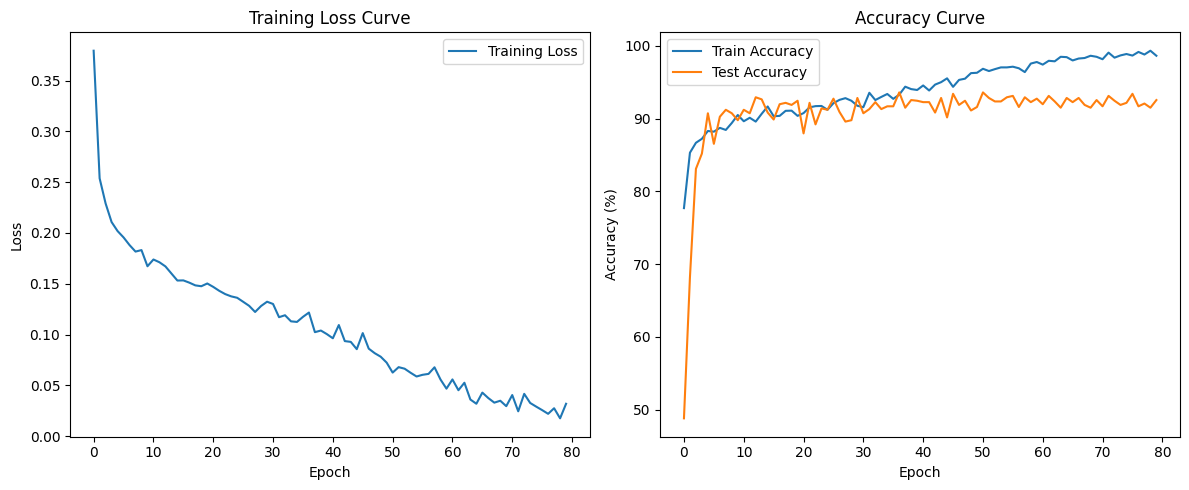

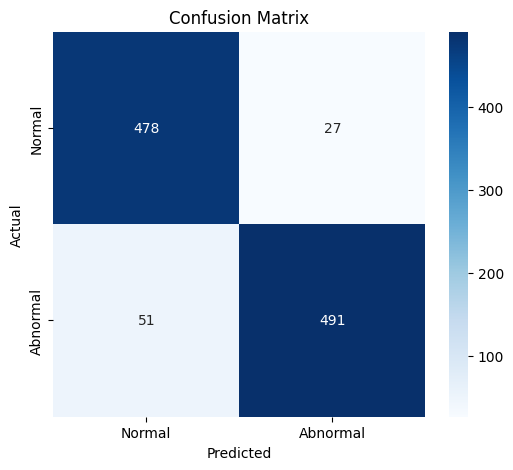

Correct prediction: Predicted Normal, Actual Normal


In [6]:

# 1. 绘制训练损失和准确率曲线
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies[1:], label='Test Accuracy')  # 跳过初始准确率
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# 2. 绘制混淆矩阵
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 打印一个预测示例
bin_labels = {0: 'Normal', 1: 'Abnormal'}
for i in range(len(y_true)):
    if y_pred[i] == y_true[i]:
        print(f"Correct prediction: Predicted {bin_labels[y_pred[i]]}, Actual {bin_labels[y_true[i]]}")
        break


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(y_true, y_pred, class_names=['Normal', 'Abnormal']):
    """
    综合评估模型性能，包含混淆矩阵和各项指标计算
    
    参数:
    y_true : array-like
        真实标签
    y_pred : array-like
        预测标签
    class_names : list
        类别名称列表
    """
    # 计算混淆矩阵
    conf_mat = confusion_matrix(y_true, y_pred)
    
    # 1. 可视化混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # 2. 计算各项指标
    n_classes = conf_mat.shape[0]
    total_samples = np.sum(conf_mat)
    
    print("\n" + "="*50)
    print("Detailed Classification Metrics:")
    print("="*50 + "\n")
    
    # 计算每个类别的指标
    metrics = []
    for i in range(n_classes):
        TP = conf_mat[i, i]
        FN = np.sum(conf_mat[i, :]) - TP
        FP = np.sum(conf_mat[:, i]) - TP
        TN = np.sum(conf_mat) - (TP + FN + FP)
        
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1_score = 2 * precision * sensitivity / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        
        metrics.append({
            'Class': class_names[i],
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'F1-Score': f1_score
        })
        
        print(f"Class: {class_names[i]}")
        print(f"  Accuracy:    {accuracy:.4f}")
        print(f"  Sensitivity: {sensitivity:.4f} (Recall)")
        print(f"  Specificity: {specificity:.4f}")
        print(f"  Precision:   {precision:.4f}")
        print(f"  F1-Score:    {f1_score:.4f}")
        print("-"*40)
    
    # 计算总体指标
    overall_accuracy = np.trace(conf_mat) / total_samples
    macro_f1 = np.mean([m['F1-Score'] for m in metrics])
    weighted_f1 = np.sum([m['F1-Score'] * np.sum(conf_mat[i, :]) for i, m in enumerate(metrics)]) / total_samples
    
    print("\nOverall Metrics:")
    print(f"  Overall Accuracy: {overall_accuracy:.4f}")
    print(f"  Macro F1-Score:   {macro_f1:.4f}")
    print(f"  Weighted F1-Score: {weighted_f1:.4f}")
    
    # 3. 使用sklearn的分类报告
    print("\n" + "="*50)
    print("sklearn Classification Report:")
    print("="*50)
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    return {
        'confusion_matrix': conf_mat,
        'class_metrics': metrics,
        'overall_accuracy': overall_accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1
    }


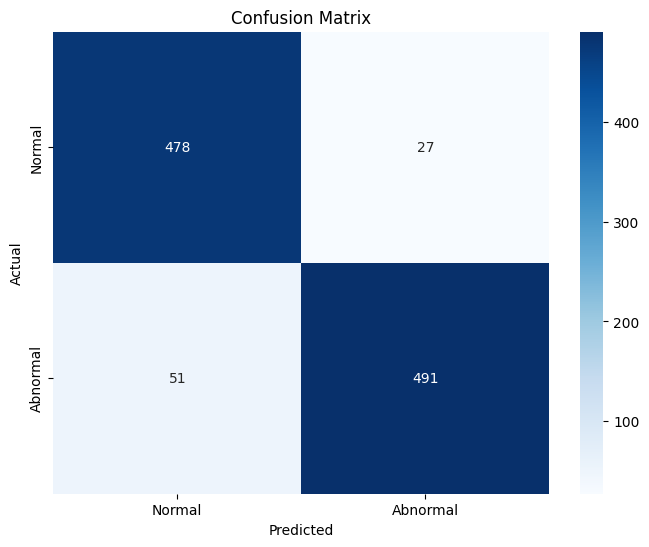


Detailed Classification Metrics:

Class: Normal
  Accuracy:    0.9255
  Sensitivity: 0.9465 (Recall)
  Specificity: 0.9059
  Precision:   0.9036
  F1-Score:    0.9246
----------------------------------------
Class: Abnormal
  Accuracy:    0.9255
  Sensitivity: 0.9059 (Recall)
  Specificity: 0.9465
  Precision:   0.9479
  F1-Score:    0.9264
----------------------------------------

Overall Metrics:
  Overall Accuracy: 0.9255
  Macro F1-Score:   0.9255
  Weighted F1-Score: 0.9255

sklearn Classification Report:
              precision    recall  f1-score   support

      Normal       0.90      0.95      0.92       505
    Abnormal       0.95      0.91      0.93       542

    accuracy                           0.93      1047
   macro avg       0.93      0.93      0.93      1047
weighted avg       0.93      0.93      0.93      1047



In [8]:
results = evaluate_model(y_true, y_pred)